### Теоретическая часть

### Задание 1

Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?  
В чем принципиальные отличия item-item рекомендаций от ALS?


#### Ответ

User-User рекомендации и Item-Item рекомендации работают похожим образом, но зеркально. User-User рекомендации для каждого отдельного товара ищут наиболее похожих пользователей. Item-Item рекомендации для каждого отдельного пользователя ищут наиболее похожие товары. Математически это одинаковые алгоритмы. Вопрос, интерпретации: что мы называем user, а что называем item.

Отсюда вытекает, что если есть функция item_item_rec(interaction_matrix), то можно просто транспонировать исходную матрицу interaction_matrix, поменяв местами user и item, и вместо Item-Item рекомендации мы получим User-User рекомендации.

В ALS матрица interaction_matrix подготавливается несколько иначе, чем item-item рекомендации. Все взаимодействия user-item, о которых мы ничего не знаем, мы присваем 0. И дальше каждому взаимодействию мы назначаем определенный вес. Таким образом различные взаимодействия в нашей матрице имеют не одинаковый вес, а сильно разный.  И оптимизируется не не просто ошибка между предсказанными и фактическими значениями, а умноженная та взвешенную матрицу (матрицу весов). 

### Задание 2 

Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров.

#### Ответ

В качестве альтернативных или дополнительных «весов» можно использовать:

* комментарии/отзывы и их количество,
* сезонность
* лояльность покупателя
* количество просмотров

### Задание 3

Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)

#### Ответ

* Огромный объем сетевого трафика: это основное узкое место всех алгоритмов распределенной матричной факторизации. Поскольку мы отправляем вектор признаков по каждому краю графа, объем данных, отправляемых по сети за одну итерацию, пропорционален #Ratings * #Features(здесь и далее в тексте мы используем # как обозначение для 'количества'). Для 100 миллиардов оценок и 100 двойных функций это приводит к 80 ТБ сетевого трафика на итерацию.
* Некоторые элементы в наших наборах данных очень популярны, поэтому распределение уровней элементов сильно искажено: это может вызвать проблемы с памятью - каждый элемент получает степень * #Features количество данных. Например, если элемент имеет 100 миллионов известных оценок и используется 100 двойных функций, только этот элемент получит 80 ГБ данных. Элементы большой степени также вызывают узкие места в обработке(поскольку каждая вершина обрабатывается атомарно), и все будут ждать завершения нескольких элементов максимальной степени.
* Полагается только на квадрат потерь.

#### Задание 4

Мы рассматривали bm_25_weight. 
Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?

#### Ответ

В классическую формулу TF-IDF добавляются дополнительные коэффициенты, за счет которых, появлюятся отличия в оценке релевантности документов (статьи, по которым я изучал алгоритм, относятся к задаче поиска документов).

1. В классическом TF-IDF вес документа будет расти пропорционально частоте вхождения ключевого слова до бесконечности. Можно "заспамить" документ ключевыми словами и получить высокую релевантность. В BM25 рост будет осуществляться ассимпотически и будет ограничен значениями добавленных коээфициентов

2. IDF для слов, которые встречаются больше чем в половине документов, могут принимать отрицательные значения

3. Короткие документы гораздо быстрее достигают насыщения по оценке TF

4. Значение Score зависит от длины документа D. Чем больше слов в документе, тем меньше будет итоговая оценка для документа.

Если я правильно понял идею, то при перевзвешивании user-item матрицы мы можем использовать сколько угодно много различных показателей явных и неявных интеракций (количество, продаж, сумма продаж, глубина просмотра, рейтинг,  популярность товара, добавление в нравится и т.д.). Разница лишь в том, что мы можем взять либо один показатель, либо составить линейную комбинацию из этих показателей, как-то подобрав веса перед ними. Либо использовать алгоритмы TF-IDF, BM25 для вычисления весов (релевантности) каждой интеракции на основе вхождения различных исходных показателей в каждую интеракцию.

В сети других идей, как можно еще перевзвесить матрицу я не нашел. Во всех статьях, которые мне попадались обычно шла речь о линейной комбинации вида $c_{i,j} = 1+\lambda \cdot r_{i,j}$. То что наверное, можно сделать линейную комбинацию нескольких разных показателей интеракции, я "додумал" уже сам. И не уверен в правильности этой идеи.

В библиотеке implicit.nearest_neighbours есть два метода: log, log(1+p). С одним из методов мы вычислили Weighted Random Recommendation. Считаю, что их можно также использовать для взвешивания матрицы. Первая функция возвращает логарифм переданного значения, вторая логарирфм от единица плюс значение.

### Практическая часть

In [1]:
!pip install implicit

     |████████████████████████████████| 1.1MB 5.8MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3403190 sha256=73182be953753342a1ca6750c369fd26d80e945c4cc58a5be8cb2d292b373cac
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

In [4]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    #print(flags)
    
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Загрузим данные

data = pd.read_csv('/content/drive/MyDrive/GB_Recommendation_systems/Data/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [7]:
result_train = data_train.groupby('user_id')['item_id'].unique().reset_index()
result_train.columns=['user_id', 'actual']
result_train.head(2)

result_test = data_test.groupby('user_id')['item_id'].unique().reset_index()
result_test.columns=['user_id', 'actual']
result_test.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [8]:
# Построим топ-5000
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [9]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [10]:
# Сформируем user_item_matrix
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,819255,819304,819308,819330,819518,819594,819643,819765,819840,819845,819927,819978,820082,820122,820165,820291,820301,820321,820361,820486,820518,820560,820701,820895,821025,821083,821200,821209,821219,821344,...,13512965,13671759,13672065,13777104,13841744,13842088,13842090,13842214,13842224,13877192,13945141,13945244,13987135,14025185,14043817,14043823,14043825,14043826,14050436,14050460,14050461,14077333,14106445,15452677,15452812,15506577,15511891,15596279,15596488,15596515,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
user_item_matrix.shape

(2499, 5001)

In [12]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [13]:
def fit_model(user_item_matrix):

    model = AlternatingLeastSquares(factors=100, #k
                                    regularization=0.001,
                                    use_gpu=False,
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    num_threads=4, 
                                    random_state=123)

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=True)

    return model


def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [14]:
precs_train = []
precs_test = []

In [15]:
%%time

model = fit_model(user_item_matrix)


CPU times: user 2min 44s, sys: 8min 36s, total: 11min 20s
Wall time: 5min 55s


In [16]:
%%time

# Обычная матрица 
result_train['als'] = result_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
prec = result_train.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
precs_train.append(prec)
prec

CPU times: user 42.7 s, sys: 33.2 s, total: 1min 15s
Wall time: 38.9 s


In [17]:
result_test['als'] = result_test['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
prec = result_test.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
precs_test.append(prec)
prec

0.15798237022526754

In [18]:
precs_train, precs_test

([0.7396558623449242], [0.15798237022526754])

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.

Количество покупок

In [19]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='sum', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) 
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,819255,819304,819308,819330,819518,819594,819643,819765,819840,819845,819927,819978,820082,820122,820165,820291,820301,820321,820361,820486,820518,820560,820701,820895,821025,821083,821200,821209,821219,821344,...,13512965,13671759,13672065,13777104,13841744,13842088,13842090,13842214,13842224,13877192,13945141,13945244,13987135,14025185,14043817,14043823,14043825,14043826,14050436,14050460,14050461,14077333,14106445,15452677,15452812,15506577,15511891,15596279,15596488,15596515,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
%%time

model = fit_model(user_item_matrix)


CPU times: user 3min 43s, sys: 11min 58s, total: 15min 41s
Wall time: 7min 57s


In [21]:
%%time

result_train['als'] = result_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
prec = result_train.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
precs_train.append(prec)
prec

CPU times: user 42.6 s, sys: 33.3 s, total: 1min 15s
Wall time: 38.5 s


In [22]:
result_test['als'] = result_test['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
prec = result_test.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
precs_test.append(prec)
prec

0.14289911851126186

Сумма покупок

In [23]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='sales_value', # Можно пробовать другие варианты
                                  aggfunc='sum', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) 
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,819255,819304,819308,819330,819518,819594,819643,819765,819840,819845,819927,819978,820082,820122,820165,820291,820301,820321,820361,820486,820518,820560,820701,820895,821025,821083,821200,821209,821219,821344,...,13512965,13671759,13672065,13777104,13841744,13842088,13842090,13842214,13842224,13877192,13945141,13945244,13987135,14025185,14043817,14043823,14043825,14043826,14050436,14050460,14050461,14077333,14106445,15452677,15452812,15506577,15511891,15596279,15596488,15596515,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.49,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.96,0.0,0.0,0.0,3.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
%%time

model = fit_model(user_item_matrix)


CPU times: user 3min 44s, sys: 12min 5s, total: 15min 50s
Wall time: 8min 2s


In [25]:
%%time

result_train['als'] = result_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
prec = result_train.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
precs_train.append(prec)
prec

CPU times: user 42.4 s, sys: 33.4 s, total: 1min 15s
Wall time: 38.5 s


In [26]:
result_test['als'] = result_test['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
prec = result_test.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
precs_test.append(prec)
prec

0.10019588638589552

Взвешенное по времени количество покупок. Чем больше номер периода, тем больше вес покупки

In [27]:
data_train['week_no_log'] = data_train['week_no'].apply(lambda x: np.log(1+x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
data_train.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,week_no_log
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,0.693147
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,0.693147
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0,0.693147


In [29]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='week_no_log', # Можно пробовать другие варианты
                                  aggfunc='sum', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) 
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,819255,819304,819308,819330,819518,819594,819643,819765,819840,819845,819927,819978,820082,820122,820165,820291,820301,820321,820361,820486,820518,820560,820701,820895,821025,821083,821200,821209,821219,821344,...,13512965,13671759,13672065,13777104,13841744,13842088,13842090,13842214,13842224,13877192,13945141,13945244,13987135,14025185,14043817,14043823,14043825,14043826,14050436,14050460,14050461,14077333,14106445,15452677,15452812,15506577,15511891,15596279,15596488,15596515,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.883086,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,4.418841,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,4.26268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.51086,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.356709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.64866,0.0,0.0,0.0,4.060443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.576217,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [30]:
%%time

model = fit_model(user_item_matrix)


CPU times: user 3min 27s, sys: 11min 8s, total: 14min 36s
Wall time: 7min 24s


In [31]:
%%time

result_train['als'] = result_train['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
prec = result_train.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
precs_train.append(prec)
prec

CPU times: user 42.8 s, sys: 33.3 s, total: 1min 16s
Wall time: 38.6 s


In [32]:
result_test['als'] = result_test['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
prec = result_test.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
precs_test.append(prec)
prec

0.08687561214495568

In [33]:
precs_train, precs_test

([0.7396558623449242,
  0.7150860344137521,
  0.5970388155262034,
  0.5314125650260095],
 [0.15798237022526754,
  0.14289911851126186,
  0.10019588638589552,
  0.08687561214495568])

In [34]:
matrixes = ['Количество покупок (транзакций)', 
            'Количество покупок (штук)',
            'Сумма покупок',
            'Взвешенное по времени количество покупок'
           ]

scores = pd.DataFrame(list(zip(matrixes, precs_train, precs_test)), columns=['matrixes','train', 'test'])
scores.set_index('matrixes')

,train,test
matrixes,,
Количество покупок (транзакций),0.739656,0.157982
Количество покупок (штук),0.715086,0.142899
Сумма покупок,0.597039,0.100196
Взвешенное по времени количество покупок,0.531413,0.086876


Выводы:

Лучшие результаты показал базовый вес - количество покупок (транзакций). Ни количество купленных единиц, ни сумма покупки, ни зависимость покупок от времени, не дали такого же результата, как просто количество покупок.

На первый взгляд наше наблюдение может показаться удивительным. Ведь такие значительные параметры покупок как количество купленных единиц этого товара и сумма покупки не дали весомый положительный эффект рекомендаций. Судя по всему, у меня 2 мысли: во-первых, предполагаю, что есть необходимость преобразовывать наши данные к другому формату или применить другой подход, отличный от нашего и во-вторых, мы не можем быть полностью уверены в том, что эти данные корректные, так как не были учтены некоторые нюансы при сборе данных. 

Предлагаю следующую книгу для более глубокого понимания сути проблемы.
В данной книге изложены основные неприятности и "капканы", в которые может угодить неопытный data scientist. Ссылка на книгу: https://www.amazon.com/9-Pitfalls-Data-Science/dp/0198844395

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [35]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', 
                                  aggfunc='sum', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) 
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,819255,819304,819308,819330,819518,819594,819643,819765,819840,819845,819927,819978,820082,820122,820165,820291,820301,820321,820361,820486,820518,820560,820701,820895,821025,821083,821200,821209,821219,821344,...,13512965,13671759,13672065,13777104,13841744,13842088,13842090,13842214,13842224,13877192,13945141,13945244,13987135,14025185,14043817,14043823,14043825,14043826,14050436,14050460,14050461,14077333,14106445,15452677,15452812,15506577,15511891,15596279,15596488,15596515,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
def ALS(user_item_matrix, factors=100, regularization=0.001, show_progress=False):

    model = AlternatingLeastSquares(factors=factors, #k
                                    regularization=regularization,
                                    use_gpu=False,
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    num_threads=4, 
                                    random_state=123)

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=show_progress)
    
    return model


def eval_precision_at_k(model, result, k=5):
    result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
    prec = result.apply(lambda row: precision_at_k(row['als'], row['actual'], k=k), axis=1).mean()
    return prec

In [37]:
factors = [20, 100, 300]
lambdas = [0.001, 0.005, 0.02]

In [38]:
import time

Переберем разные значения для factors

In [39]:
%%time

precisions_train = []
precisions_test = []
learn_durations = []

for factor in factors:
    
    start_time = time.time()
    model = ALS(user_item_matrix, factors=factor, show_progress=True)
    learn_durations.append(time.time() - start_time)
    
    precisions_train.append(eval_precision_at_k(model, result_train))
    precisions_test.append(eval_precision_at_k(model, result_test))
    
precisions_train, precisions_test, learn_durations


CPU times: user 22min 7s, sys: 46min 58s, total: 1h 9min 5s
Wall time: 35min 30s


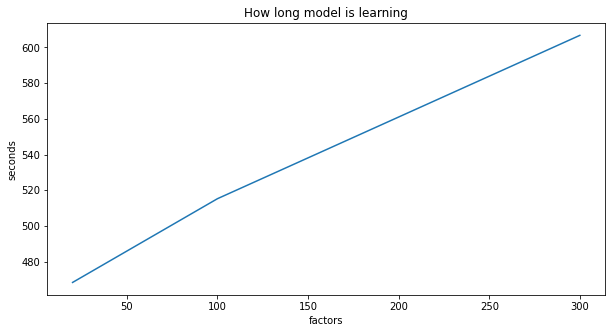

In [40]:
fig, ax = plt.subplots(figsize=(10, 5), )
ax.plot(factors, learn_durations)

plt.xlabel('factors')
plt.ylabel('seconds')
plt.title('How long model is learning')
plt.show();

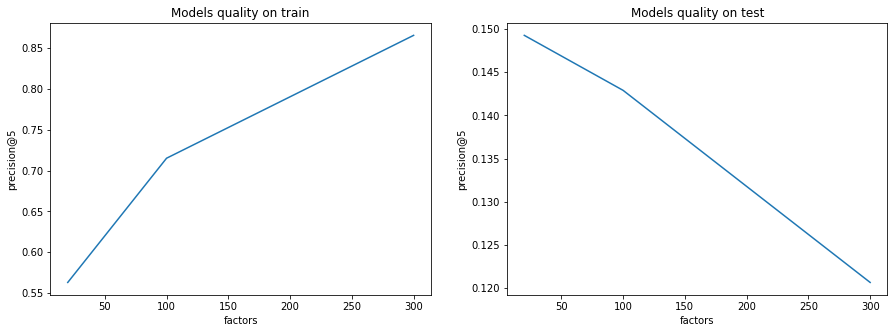

In [41]:
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(factors, precisions_train, label='precision@5 on train')
ax1.set_title('Model''s quality on train')
ax1.set_xlabel("factors")
ax1.set_ylabel("precision@5")

ax2.plot(factors, precisions_test, label='precision@5 on test')
ax2.set_xlabel("factors")
ax2.set_ylabel("precision@5")
ax2.set_title('Model''s quality on test')              

plt.show();

Переберем разные значения для lambda

In [42]:
%%time

precisions_train2 = []
precisions_test2 = []
learn_durations2 = []

for lambda_ in lambdas:
    
    start_time = time.time()
    model = ALS(user_item_matrix, regularization=lambda_, show_progress=True)
    learn_durations2.append(time.time() - start_time)
    
    precisions_train2.append(eval_precision_at_k(model, result_train))
    precisions_test2.append(eval_precision_at_k(model, result_test))
    
precisions_train2, precisions_test2, learn_durations2


CPU times: user 15min 36s, sys: 40min 38s, total: 56min 14s
Wall time: 28min 30s


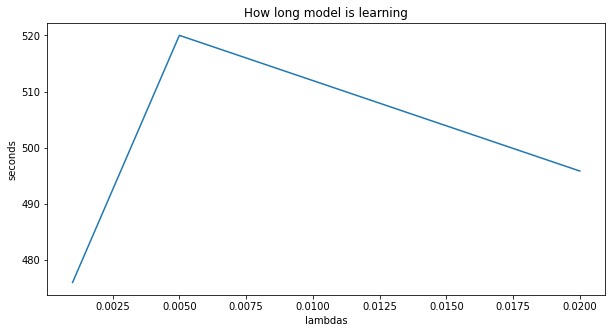

In [43]:
fig, ax = plt.subplots(figsize=(10, 5), )
ax.plot(lambdas, learn_durations2)

plt.xlabel('lambdas')
plt.ylabel('seconds')
plt.title('How long model is learning')
plt.show();

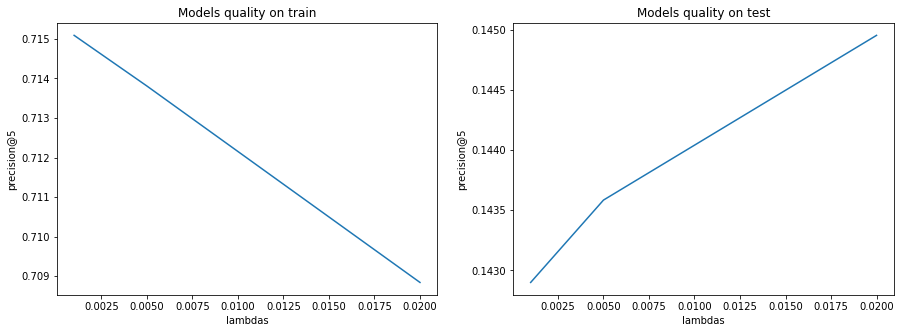

In [44]:
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(lambdas, precisions_train2, label='precision@5 on train')
ax1.set_title('Model''s quality on train')
ax1.set_xlabel("lambdas")
ax1.set_ylabel("precision@5")

ax2.plot(lambdas, precisions_test2, label='precision@5 on test')
ax2.set_xlabel("lambdas")
ax2.set_ylabel("precision@5")
ax2.set_title('Model''s quality on test')              

plt.show();

#### Выводы:

С ростом количества факторов растет время, затрачиваемое на обучение модели. Причем растет нелинейно. Характер похож на экспоненту. Что вполне ожидаемо, так как вычислительная сложность алгоритма при увеличении числа факторов тоже должна расти.

Перейдем к качеству моделей. С ростом числа факторов качество модели на train растет (приближается к некой ассимптоте), а на test сначала достигает некоего максимума, а потом начинает падать. Видно, как модель сильно переобучается. Отсюда можно сделать вывод, что оптимальное количество факторов надо подбирать, причем оптимальнео значение скорее будет в области не очень больших значений.

Рассмотрим коэффициент регуляризации $\lambda$.

Время обучения почти не зависит от разных значений этого параметра. Можно сказать, что время обучения от разных $\lambda$ не зависит.

С качеством обучения метрика картинка другая. Чем больше параметр регуляризации, тем хуже значеня на train. А на тест, результат сначала резко растет, достигает некоторого максимума, а дальше постепенно снижается, причем плавно замедляясь.

Отсюда вывод, что параметр регуляризации необходимо подбирать. Но даже, если установить этот параметр немного выше, это понизит общее качество предсказания, хотя не так сильно и при этом модель все равно будет устойчива.

**P.S.** Не пишите отписки в качестве выводов. Мне интресены Ваши рассуждения, трудности, с которыми Вы сталкнулись и что-то, что Вас удивило. Если выводы контринтуитивны - напишите об этом, в этом нет ничего страшного!